<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/Lecture_04_Component_Segmentation-Exemplo-Analises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

In [3]:
!wget https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/Images.zip -O Images.zip
!unzip -o Images.zip

--2023-08-28 21:53:06--  https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/Images.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrehochuli/teaching/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/Images.zip [following]
--2023-08-28 21:53:07--  https://raw.githubusercontent.com/andrehochuli/teaching/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3413100 (3.3M) [application/zip]
Saving to: ‘Images.zip’

Images.zip          100%[===================>]   3

#License Plate Characters Segmentation
The goal is to segment the chars and numbers from a license plate


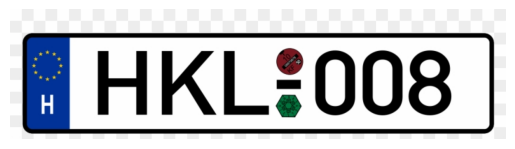

In [4]:
#read image from disk
img_plate = cv2.imread('Images/placa5.png')
#converts to rgb to better visualize
img_plate = cv2.cvtColor(img_plate,cv2.COLOR_BGR2RGB)
plt.imshow(img_plate)
plt.axis('off')
plt.show()

#Connected Component Labelling - Classical Algorithm
* Analyzes the non-zero pixel's neighborhood (foreground)
* Label each connected pixel with a label (1,2,3,4….)

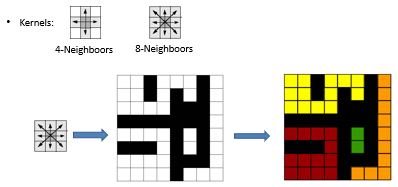

The method is implemented by cv2.connectedComponent() function





#Pre-Processing

First, we must binarize the image to segment the foreground and background.
  * Blurring to reduce brightness changes and other noises
  * Otsu threshold to binarize

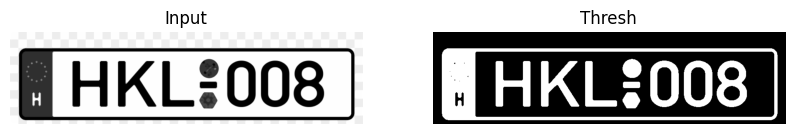

In [12]:
gray = cv2.cvtColor(img_plate,cv2.COLOR_RGB2GRAY)

gray = cv2.medianBlur(gray,5)

_,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plot_sidebyside([gray,thresh],['Input','Thresh'],colormap='gray',figsize=(10,6))

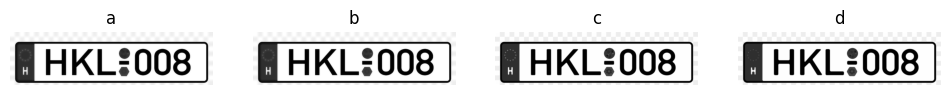

In [15]:
gray = cv2.cvtColor(img_plate,cv2.COLOR_RGB2GRAY)
bilateral1 = cv2.bilateralFilter(gray, 15, 75, 75)
bilateral2 = cv2.bilateralFilter(gray, 15, 75, 95)
blur1 = cv2.medianBlur(gray,5)
blur2 = cv2.medianBlur(gray,7)
plot_sidebyside([bilateral1,bilateral2,blur1,blur2],['a','b','c','d'],colormap='gray')

Discussão: Visto que a cor não é relevante em placas, converti para nivel de cinza.

Aqui verificamos se o uso de filtros poderia melhorar os ruídos.

Foram analisadas duas funções de filtering e conclui-se que não houve diferença entre as abordagens. Portanto escolhemos a função blur1.

threshold 127 + otsu


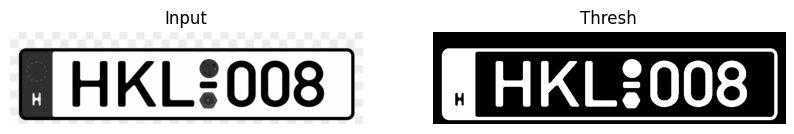

threshold 50 , sem otsu


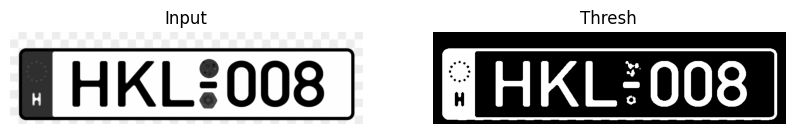

In [17]:
print("threshold 127 + otsu")
_,thresh = cv2.threshold(blur2,127,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plot_sidebyside([blur2,thresh],['Input','Thresh'],colormap='gray',figsize=(10,6))

print("threshold 50 , sem otsu")
_,thresh = cv2.threshold(blur2,50,255,cv2.THRESH_BINARY_INV)
plot_sidebyside([blur2,thresh],['Input','Thresh'],colormap='gray',figsize=(10,6))

Afim de criar as mascaras, binarizamos a imagem utilizando otsu com threshold em 127 e somente threshold 50.

Com base nisso, a imagem com otsu denota melhor os componentes.

#The cv2.connectedComponent()
*   Returns the number of labels find
*   The labeled image
*   List of properties of components (top-left, size, area, etc.)



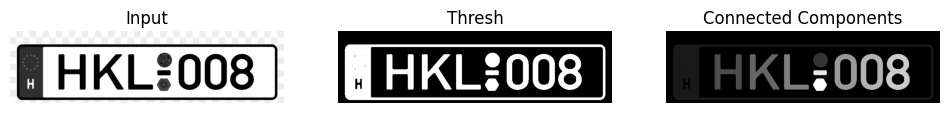

Total Labels: 11
[ 0  1  2  3  4  5  6  7  8  9 10]


In [6]:
connectivity = 4  # You need to choose 4 or 8 for connectivity type
num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(thresh , connectivity , cv2.CV_32S)
plot_sidebyside([gray,thresh,cc_image],['Input','Thresh','Connected Components'],colormap='gray')

print('Total Labels:', num_labels)
print(np.unique(cc_image))

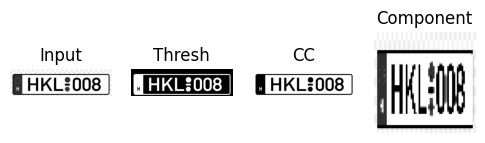

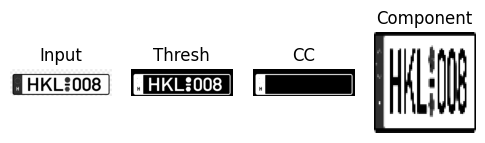

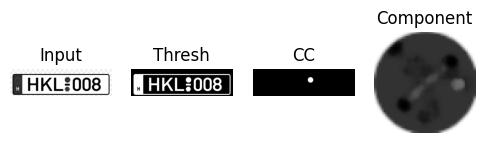

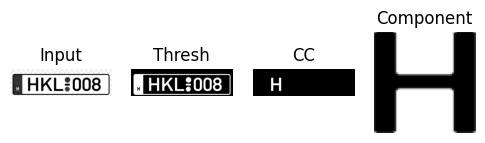

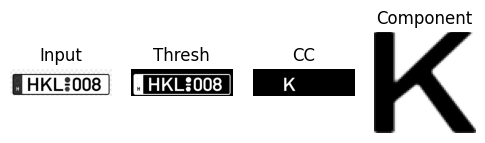

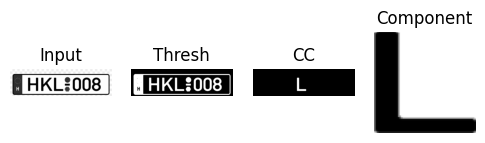

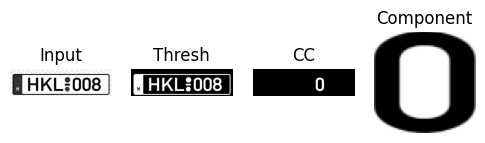

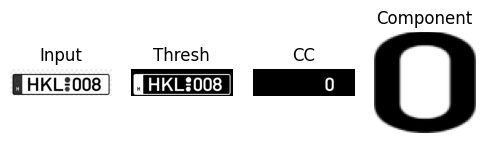

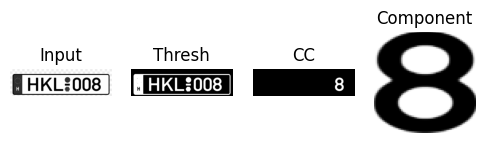

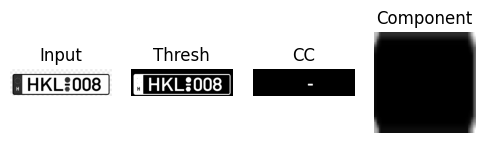

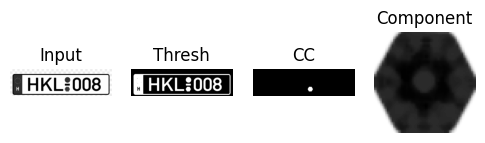

In [7]:
for i in range(num_labels):
  temp = cc_image.copy()

  temp[cc_image == i] = 255
  temp[cc_image != i] = 0

  x,y,w,h = stats[i][:4]
  area = stats[i][4]
  cx,cy = centroids[i]
  component = gray[y:y+h, x:x+w]
  component = cv2.resize(component,(64,64))
  plot_sidebyside([gray,thresh,temp,component],['Input','Thresh','CC','Component'],colormap='gray',figsize=(6,6))

#Filtering components by size
  We can observe that chars and numbers has a pattern in size (~110 pixels of heigth) that permit to filtering amoung others components.
  Lets, take a look!

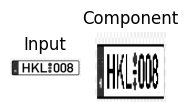

840 220


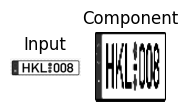

799 170


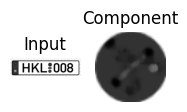

45 45


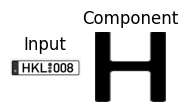

83 108


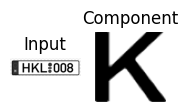

91 108


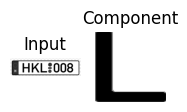

76 108


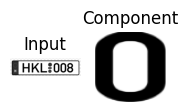

68 110


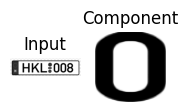

68 110


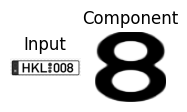

72 110


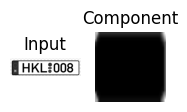

41 15


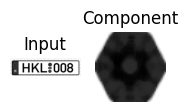

42 38


In [8]:
for i in range(num_labels):
  temp = cc_image.copy()

  temp[cc_image == i] = 255
  temp[cc_image != i] = 0

  #x,y = top-left coordinates
  #w,h = width and height of bounding box
  x,y,w,h = stats[i][:4]

  #number of foreground pixels
  area = stats[i][4]

  #center of mass (cx,cy)
  cx,cy = centroids[i]

  component = gray[y:y+h, x:x+w]
  component = cv2.resize(component,(64,64))
  plot_sidebyside([gray,component],['Input','Component'],colormap='gray',figsize=(2,2))
  print(w,h)

Adicionamos um 'if' para filtrar apenas as letras e números

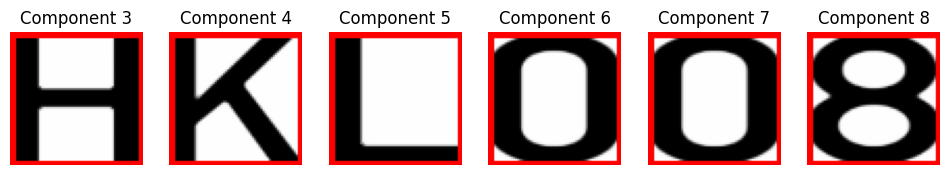

In [9]:
comp_img = []
comp_str = []

for i in range(num_labels):
  temp = cc_image.copy()

  temp[cc_image == i] = 255
  temp[cc_image != i] = 0

  x,y,w,h = stats[i][:4]
  area = stats[i][4]
  cx,cy = centroids[i]


  if h > 90 and h < 130:
    component = gray[y:y+h, x:x+w]
    h,w = component.shape

    component = cv2.resize(component,(64,64))
    component = cv2.cvtColor(component,cv2.COLOR_GRAY2BGR)
    cv2.rectangle(component,(0,0),(64,64),(255,0,0),thickness=3)
    comp_img.append(component)
    comp_str.append('Component ' + str(i))


plot_sidebyside(comp_img,comp_str,colormap='gray')



Now, it´s up to you! Try this approach to the other license plates.

* Challenge 01: Implement an algorithm that works for most plates. You will need to deal with size normalization, noise reduction, etc.

* Challenge 02: Classification Challenge: How can we determine the character?

   **Here´s a tip**: Try to implement an approach that computes an image difference to a character reference dataset set! The closest one is the char or number label. Moreover, search for the Template Matching technique and figure out how you can apply it to this end.

> The reasoning is to create a dataset with all the characters, commonly named 'reference dataset.' It is easy since you can draw them by using the function cv2.puttext.
> Then, for each character extracted from the license plate, you can compare it with the reference set. The closest one will determine the label.

Link for dataset:
https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/dataset.zip




In [10]:
!wget https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/dataset.zip -O dataset.zip
!unzip dataset.zip


--2023-08-28 21:53:12--  https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrehochuli/teaching/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/dataset.zip [following]
--2023-08-28 21:53:13--  https://raw.githubusercontent.com/andrehochuli/teaching/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2220323 (2.1M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]